In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

## load  channel name and cell type info

<!-- 	ON	ON/OFF	OFF	Unknown	Sum
count	32	10	13	52	107 -->


In [2]:
dataset = '20180828'

data_path = os.path.join('data1', dataset)


width = 8
height = 8
fps = 10

width = 8
height = 8
fps = 25

width = 13
height = 13
fps = 10

width = 26
height = 26
fps = 10

In [3]:
# read the csv file
info = pd.read_csv(os.path.join(data_path, 'cell_type_{}pix_{}Hz.csv'.format(width, fps)))

info.replace('-', 'Unknown', inplace=True)

info

,channel,cell_type
0,12a,OFF
1,12b,Unknown
2,12c,ON
3,12d,OFF
4,12e,ON
...,...,...
103,83b,Unknown
104,84a,Unknown
105,86a,Unknown
106,86b,Unknown


In [4]:
info['cell_type'].value_counts()[['ON', 'OFF', 'Unknown']] / len(info)

ON         0.296296
OFF        0.277778
Unknown    0.425926
Name: cell_type, dtype: float64

## load stim

In [5]:
stim_info_path = glob(os.path.join(data_path,'StimInfo_{}pix_*_{}Hz.mat'.format(width, fps)))[0]
stim_info_path
# stim_info_path = os.path.join(data_path,'StimInfo_8pix_215um_10Hz.mat')

'data1/20180828/StimInfo_26pix_66um_10Hz.mat'

In [6]:
# read stimulus
import scipy.io as sio
stim = list()
for stim_info in sio.loadmat(stim_info_path)['StimInfo']:
    stim.append(stim_info[0][0])
    # print(stim_info[0][0].shape)
stim = np.array(stim)

In [7]:
stim.shape

(9000, 676)

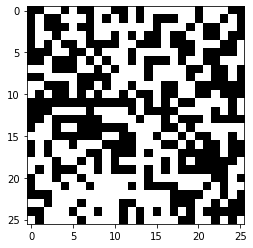

In [8]:
plt.imshow(stim[0,:].reshape(height,width), cmap='gray')

## load spike counts

In [9]:
def count_spikes(spike_times, bins, timestamp_start=0):
    num_bins = bins.shape[0]
    spike_count = np.zeros_like(bins)
    for i in range(num_bins):
        if i == 0:
            continue

        spike_count[i] = np.sum(np.logical_and(spike_times >= timestamp_start + bins[i-1], spike_times < timestamp_start + bins[i]))
    return spike_count

In [10]:
# read spike counts
path = glob(os.path.join(data_path, 'SpikeTrain_'+dataset,  'SpikeTrain_ND2_{}pix_*_{}Hz'.format(width,fps)))[0]

# load time stamps
filename = os.path.join(path, 'A1a.mat')
print(filename)
ts = sio.loadmat(filename)['A1a'].ravel()
# print(ts[0], ts[-1], ts.shape)

# load spike times
# channel_names = list()
spike_counts = list()
for i, channel_name in enumerate(tqdm(info['channel'])):
    filename = os.path.join(path, 'ch_' + channel_name)
    # print(filename)
    spike_time = sio.loadmat(filename)['ch_' + channel_name].ravel()

    # count spikes
    spike_counts.append(count_spikes(spike_time, ts))

spike_counts = np.array(spike_counts)

  1%|          | 1/108 [00:00<00:20,  5.18it/s]

data1/20180828/SpikeTrain_20180828/SpikeTrain_ND2_26pix_66um_10Hz/A1a.mat


100%|██████████| 108/108 [00:15<00:00,  6.86it/s]


In [11]:
spike_counts.shape

(108, 9000)

(array([711688., 153088.,  58199.,  25019.,  11695.,   5742.,   3005.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5]),
 <a list of 7 Patch objects>)

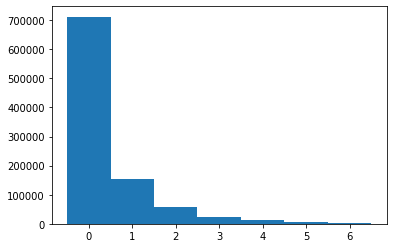

In [12]:
plt.hist(spike_counts.ravel(), [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])

## save to npz and csv

put these files under `data`

In [13]:
basename = dataset+'_{}pix_{}Hz'.format(width, fps)

np.savez(basename, dataset=dataset, stim=stim, spike_counts=spike_counts)

info.to_csv(basename+'_info.csv', index=None)